In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import geopandas as gpd
import osmnx as ox
import contextily as cx
import urbanpy as up
from tqdm.auto import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
gdf_celdas = gpd.read_parquet("outputs/gdf_celdas_final_2025_07_29.parquet")
gdf_celdas.head()

,cell_id,polygon_id,category,country,pop_total,pop_primary_school_age,pop_middle_school_age,pop_secondary_school_age,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,duration_to_nearest_primary_schools_label,distance_to_nearest_middle_schools,duration_to_nearest_middle_schools,duration_to_nearest_middle_schools_label,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,geometry
0,13887,02595-2-1,urban_area,bol,0.000000,0.000000,0.000000,0.000000,1.6730,20.075000,15-30,1.6730,20.075000,15-30,1.6730,20.075000,15-30,"POLYGON ((-69.57156 -10.95204, -69.57038 -10.9..."
1,13887,02595-2-1,urban_area,bra,29.889341,10.580689,9.726920,9.581732,1.6730,20.075000,15-30,1.6730,20.075000,15-30,1.6730,20.075000,15-30,"POLYGON ((-69.57156 -10.95204, -69.57038 -10.9..."
2,13956,08801-1-1,non_urban_area,bol,0.205296,0.071269,0.065288,0.068739,1.0347,12.415000,0-15,1.0347,12.415000,0-15,1.0347,12.415000,0-15,"POLYGON ((-69.21655 -11.14754, -69.21536 -11.1..."
3,13993,06399-1-1,non_urban_area,bol,4.057443,1.408542,1.290350,1.358551,0.2030,2.436667,0-15,0.2030,2.436667,0-15,0.2030,2.436667,0-15,"POLYGON ((-69.06537 -11.28604, -69.06416 -11.2..."
4,13998,08147-1-1,non_urban_area,bol,2.743381,0.952365,0.872452,0.918565,0.5786,6.943333,0-15,0.5786,6.943333,0-15,0.5786,6.943333,0-15,"POLYGON ((-69.02062 -11.18827, -69.01942 -11.1..."


In [3]:
print("Numer of cells without access:")
(
    gdf_celdas[
        [
            "duration_to_nearest_primary_schools_label",
            "duration_to_nearest_middle_schools_label",
            "duration_to_nearest_secondary_schools_label",
        ]
    ]
    == "No access"
).sum()

Numer of cells without access:


duration_to_nearest_primary_schools_label      1949
duration_to_nearest_middle_schools_label       1193
duration_to_nearest_secondary_schools_label    1727
dtype: int64

In [4]:
gdf_celdas[gdf_celdas["duration_to_nearest_primary_schools_label"] == "No access"][
    "category"
].value_counts()

category
non_urban_area    1756
urban_area         193
Name: count, dtype: int64

In [5]:
# Load amazon boundaries
amazon = gpd.read_file("/Users/claudio/Documents/amazonia-bid/inputs/Amazonas")
amazon.crs.to_string()

'ESRI:102033'

In [6]:
# Convert to mercator and get the polygon
amazon_poly = amazon.to_crs(4326).geometry[0]

In [7]:
# Load south american rivers. Source: https://www.hydrosheds.org/products/hydrorivers
south_american_rivers_gdf = gpd.read_parquet(
    "outputs/HydroRIVERS_v10_south_america.parquet"
)
south_american_rivers_gdf.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,60000001,0,60000001,0.97,0.0,6.5,3.73,3.7,0,0.109,1,1,7,6120035220,"LINESTRING (-61.125 14.86667, -61.11875 14.87292)"
1,60000002,0,60000002,1.16,0.0,5.3,4.98,5.0,0,0.147,1,2,7,6120035220,"LINESTRING (-61.11875 14.8625, -61.11875 14.87..."
2,60000003,0,60000003,3.37,0.0,7.2,8.09,7.5,0,0.217,1,1,7,6120035220,"LINESTRING (-61.15208 14.85, -61.15208 14.8645..."
3,60000004,0,60000004,3.37,0.0,6.3,11.41,11.2,0,0.329,1,1,7,6120035220,"LINESTRING (-61.17292 14.84583, -61.17292 14.8..."
4,60000005,0,60000005,3.07,0.0,7.9,6.64,6.4,0,0.187,1,1,7,6120035220,"LINESTRING (-61.11667 14.84375, -61.11042 14.8..."


In [8]:
# south_american_rivers_gdf.to_parquet(
#     "outputs/HydroRIVERS_v10_south_america.parquet"
# )

In [9]:
south_american_rivers_gdf.shape

(1620963, 15)

In [10]:
# Filter rivers within Amazon bounds
minx, miny, maxx, maxy = amazon_poly.bounds
amazon_rivers_gdf = south_american_rivers_gdf.cx[minx:maxx, miny:maxy]

In [11]:
# amazon_rivers_gdf.to_parquet(
#     "outputs/HydroRIVERS_v10_amazon.parquet"
# )

In [12]:
gdf_celdas.loc[:, "lon"] = gdf_celdas.centroid.x
gdf_celdas.loc[:, "lat"] = gdf_celdas.centroid.y

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/438060475.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_celdas.loc[:, "lon"] = gdf_celdas.centroid.x
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/438060475.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_celdas.loc[:, "lat"] = gdf_celdas.centroid.y


In [13]:
# Filter the isolate cells for each edu level
isolated_cells_primary = gdf_celdas[
    gdf_celdas["duration_to_nearest_primary_schools_label"] == "No access"
]
isolated_cells_secondary = gdf_celdas[
    gdf_celdas["duration_to_nearest_secondary_schools_label"] == "No access"
]
isolated_cells_middle = gdf_celdas[
    gdf_celdas["duration_to_nearest_middle_schools_label"] == "No access"
]

In [48]:
polygon_example = isolated_cells_primary.iloc[[2]]

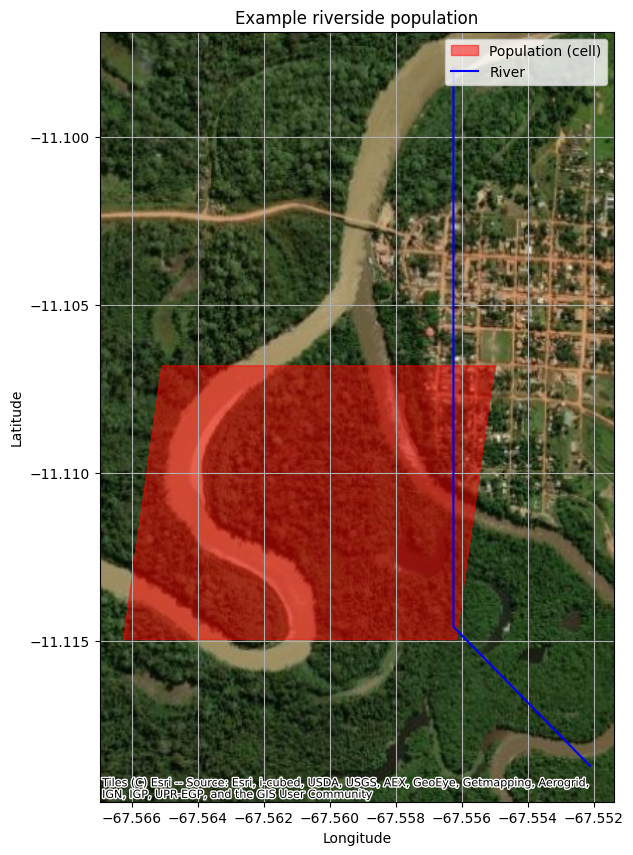

In [49]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
polygon_example.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5)

amazon_rivers_gdf[
    amazon_rivers_gdf.intersects(polygon_example.iloc[0]["geometry"])
].plot(ax=ax, color="blue")

# Add the basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Example riverside population")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

pop_patch = mpatches.Patch(color="red", label="Population (cell)", alpha=0.5)
river_line = mlines.Line2D([], [], color="blue", label="River")

ax.legend(handles=[pop_patch, river_line], loc="upper right")

# Show the plot
plt.show()

In [50]:
isolated_cells_primary_proj = ox.project_gdf(isolated_cells_primary)
isolated_cells_middle_proj = ox.project_gdf(isolated_cells_middle)
isolated_cells_secondary_proj = ox.project_gdf(isolated_cells_secondary)
amazon_rivers_gdf_proj = amazon_rivers_gdf.to_crs(
    isolated_cells_primary_proj.crs.to_string()
)

In [51]:
isolated_cells_primary_wrivers_proj = isolated_cells_primary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [52]:
isolated_cells_primary_wrivers_proj.shape[0], isolated_cells_primary_proj.shape[0]

(1919, 1949)

In [53]:
isolated_cells_primary_wrivers_proj.distance_to_river.isna().sum()

np.int64(588)

In [54]:
isolated_cells_secondary_wrivers_proj = isolated_cells_secondary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [55]:
isolated_cells_middle_wrivers_proj = isolated_cells_middle_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [56]:
isolated_cells_primary_wrivers_proj

,cell_id,polygon_id,category,country,pop_total,pop_primary_school_age,pop_middle_school_age,pop_secondary_school_age,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,...,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,distance_to_river
77,14243,05659-1-1,non_urban_area,bol,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,99.0,23.95,2462.5,0.0,30.954,5.0,5.0,5.0,6.120581e+09,0.0
78,14244,09253-1-1,non_urban_area,bol,0.390922,0.130375,0.129348,0.131199,0.0,0.0,...,99.0,23.95,2462.5,0.0,30.954,5.0,5.0,5.0,6.120581e+09,0.0
270,14806,02794-1-1,non_urban_area,bol,19.360972,6.721164,6.157186,6.482622,0.0,0.0,...,435.0,6.11,13618.8,0.0,302.992,5.0,5.0,4.0,6.120511e+09,0.0
271,14807,02794-1-1,non_urban_area,bol,37.551329,13.035948,11.942093,12.573288,0.0,0.0,...,435.0,6.11,13618.8,0.0,302.992,5.0,5.0,4.0,6.120511e+09,0.0
286,14842,08866-1-1,non_urban_area,bol,0.479630,0.166504,0.152532,0.160594,0.0,0.0,...,25.4,30.03,94.3,0.0,2.020,2.0,7.0,6.0,6.121171e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35362,35477,04394-1-1,non_urban_area,bra,86.500083,29.331085,28.196283,28.972714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35363,35478,04394-1-1,non_urban_area,bra,63.682124,21.593804,20.758352,21.329967,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35364,35490,04394-1-1,non_urban_area,bra,170.997419,57.983065,55.739737,57.274618,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35365,35491,04394-1-1,non_urban_area,bra,105.967342,35.932186,34.541994,35.493162,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
data = {
    "Level": ["Primary", "Middle", "Secondary"],
    "Total isolated (= No Access)": [
        isolated_cells_primary_proj.shape[0],
        isolated_cells_middle_proj.shape[0],
        isolated_cells_secondary_proj.shape[0],
    ],
    "Not near river": [
        isolated_cells_primary_wrivers_proj.distance_to_river.isna().sum(),
        isolated_cells_middle_wrivers_proj.distance_to_river.isna().sum(),
        isolated_cells_secondary_wrivers_proj.distance_to_river.isna().sum(),
    ],
    "Near river": [
        isolated_cells_primary_wrivers_proj.distance_to_river.notna().sum(),
        isolated_cells_middle_wrivers_proj.distance_to_river.notna().sum(),
        isolated_cells_secondary_wrivers_proj.distance_to_river.notna().sum(),
    ],
}

df_summary = pd.DataFrame(data)
df_summary["% Not near river"] = round(
    100 * df_summary["Not near river"] / df_summary["Total isolated (= No Access)"], 2
)
df_summary

,Level,Total isolated (= No Access),Not near river,Near river,% Not near river
0,Primary,1949,588,1331,30.17
1,Middle,1193,341,821,28.58
2,Secondary,1727,501,1195,29.01


In [58]:
# Calculate total population for each education level and river proximity
levels = ["Primary", "Middle", "Secondary"]
pop_columns = [
    (
        "isolated_cells_primary",
        "isolated_cells_primary_wrivers_proj",
        "pop_primary_school_age",
    ),
    (
        "isolated_cells_middle",
        "isolated_cells_middle_wrivers_proj",
        "pop_middle_school_age",
    ),
    (
        "isolated_cells_secondary",
        "isolated_cells_secondary_wrivers_proj",
        "pop_secondary_school_age",
    ),
]
results = []
for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    iso = globals()[iso_name]
    wriver = globals()[wriver_name]
    # Isolated: sum of pop_total in all isolated cells
    pop_isolated = iso[pop_col].sum()
    # Not near river: sum of pop_total where distance_to_river isna()
    pop_not_near_river = wriver[wriver["distance_to_river"].isna()][pop_col].sum()
    # Near river: sum of pop_total where distance_to_river is notna()
    pop_near_river = wriver[wriver["distance_to_river"].notna()][pop_col].sum()
    results.append(
        [level, int(pop_isolated), int(pop_not_near_river), int(pop_near_river)]
    )

df_pop_summary = pd.DataFrame(
    results,
    columns=[
        "Level",
        "Total isolated population",
        "Not near river population",
        "Near river population",
    ],
)
df_pop_summary

,Level,Total isolated population,Not near river population,Near river population
0,Primary,25402,9974,15130
1,Middle,25072,11356,13303
2,Secondary,22139,9503,12460


In [59]:
amazon_rivers_gdf

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
7452,60007453,60007355,60007489,1.81,64.7,7.4,15.01,15.0,0,0.147,1,3,7,6120978380,"LINESTRING (-75.13125 10.05833, -75.13125 10.0..."
7453,60007454,60007414,60001946,0.97,355.6,6.3,12.89,12.9,0,0.148,1,3,7,6120060050,"LINESTRING (-74.45417 10.05833, -74.46042 10.0..."
7455,60007456,60007457,60001946,0.97,573.3,6.2,7.40,7.4,0,0.115,1,6,7,6120059830,"LINESTRING (-74.1125 10.05833, -74.10625 10.06..."
7459,60007460,60007388,60010615,5.01,143.3,8.5,29.59,29.6,0,0.387,1,3,7,6120978540,"LINESTRING (-72.925 10.05833, -72.91875 10.064..."
7460,60007461,60007327,60008962,4.50,62.1,9.2,20.50,20.5,0,0.207,1,2,7,6120059580,"LINESTRING (-72.53333 10.05833, -72.52708 10.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305842,61305843,61306679,61504467,15.26,2677.0,25.4,36.98,66.5,0,0.032,2,6,8,6120719050,"LINESTRING (-60.93958 -20.52292, -60.93125 -20..."
1305912,61305913,61306447,61504467,15.40,2510.7,18.6,89.03,89.0,0,0.255,1,4,7,6121252140,"LINESTRING (-63.60417 -20.525, -63.62708 -20.5..."
1305989,61305990,61306302,61504467,15.27,2854.2,22.9,40.20,66.1,0,0.025,2,4,8,6121252380,"LINESTRING (-61.98125 -20.51875, -61.98125 -20..."
1306069,61306070,61303547,61298122,16.41,64.5,40.3,37.78,308.2,1,0.015,3,3,8,6120715560,"LINESTRING (-67.11458 -20.64792, -67.11458 -20..."


In [60]:
amazon_rivers_gdf_proj.shape

(1226115, 15)

In [61]:
amazon_rivers_gdf_proj["MAIN_RIV"].isin(
    isolated_cells_primary_wrivers_proj["MAIN_RIV"].dropna().unique()
).sum()

np.int64(1020085)

In [62]:
amazon_rivers_gdf_proj["MAIN_RIV"].unique().shape

(2921,)

In [63]:
isolated_cells_primary_wrivers_proj.isna().sum()

cell_id                                          0
polygon_id                                       0
category                                         0
country                                          0
pop_total                                        0
pop_primary_school_age                           0
pop_middle_school_age                            0
pop_secondary_school_age                         0
distance_to_nearest_primary_schools            149
duration_to_nearest_primary_schools            149
duration_to_nearest_primary_schools_label        0
distance_to_nearest_middle_schools             185
duration_to_nearest_middle_schools             185
duration_to_nearest_middle_schools_label         0
distance_to_nearest_secondary_schools          124
duration_to_nearest_secondary_schools          124
duration_to_nearest_secondary_schools_label      0
geometry                                         0
lon                                              0
lat                            

In [64]:
amazon_schools = gpd.read_parquet("outputs/amazon_schools.parquet")
amazon_schools.head()

,id_edificio,nivel_inicial,nivel_primaria,nivel_media,nivel_secundaria,latitud,longitud,area,internet,internet_tipo,electricidad,electricidad_tipo,DESIGN,ASQKM,POPGHS25,DENS,geometry,country_code
0,BOL00002,0,1,0,0,-20.010582,-64.434413,NaN,NaN,None,NaN,None,AmazoniaForever360+ area,8307960.498,5.996527e+07,7.217809,POINT (-64.43441 -20.01058),BOL
1,BOL00005,0,1,0,0,-19.929181,-64.418177,NaN,NaN,None,NaN,None,AmazoniaForever360+ area,8307960.498,5.996527e+07,7.217809,POINT (-64.41818 -19.92918),BOL
2,BOL00006,1,1,0,0,-19.966962,-64.397147,NaN,NaN,None,NaN,None,AmazoniaForever360+ area,8307960.498,5.996527e+07,7.217809,POINT (-64.39715 -19.96696),BOL
3,BOL00007,0,1,1,1,-20.105301,-64.413994,NaN,NaN,None,NaN,None,AmazoniaForever360+ area,8307960.498,5.996527e+07,7.217809,POINT (-64.41399 -20.1053),BOL
4,BOL00009,0,1,0,0,-19.943633,-64.352435,NaN,NaN,None,NaN,None,AmazoniaForever360+ area,8307960.498,5.996527e+07,7.217809,POINT (-64.35244 -19.94363),BOL


In [65]:
amazon_schools.loc[:, "lon"] = amazon_schools.geometry.x
amazon_schools.loc[:, "lat"] = amazon_schools.geometry.y

In [66]:
amazon_schools_primary = amazon_schools[amazon_schools["nivel_primaria"] == 1]
amazon_schools_middle = amazon_schools[amazon_schools["nivel_media"] == 1]
amazon_schools_secondary = amazon_schools[amazon_schools["nivel_secundaria"] == 1]

In [67]:
amazon_schools_primary_proj = amazon_schools_primary.to_crs(amazon_rivers_gdf_proj.crs)
amazon_schools_middle_proj = amazon_schools_middle.to_crs(amazon_rivers_gdf_proj.crs)
amazon_schools_secondary_proj = amazon_schools_secondary.to_crs(
    amazon_rivers_gdf_proj.crs
)

In [68]:
amazon_schools_primary_wrivers_proj = amazon_schools_primary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=500,
    distance_col="distance_to_river",  # 1km
).dropna(subset="distance_to_river")

amazon_schools_middle_wrivers_proj = amazon_schools_middle_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=500,
    distance_col="distance_to_river",  # 1km
).dropna(subset="distance_to_river")

amazon_schools_secondary_wrivers_proj = amazon_schools_secondary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=500,
    distance_col="distance_to_river",  # 1km
).dropna(subset="distance_to_river")

In [69]:
amazon_schools_primary_wrivers = amazon_schools_primary_wrivers_proj.to_crs(4326)
amazon_schools_middle_wrivers = amazon_schools_middle_wrivers_proj.to_crs(4326)
amazon_schools_secondary_wrivers = amazon_schools_secondary_wrivers_proj.to_crs(4326)

In [70]:
print(
    str(
        amazon_schools_primary_wrivers.intersects(
            polygon_example.iloc[0]["geometry"].buffer(0.1)
        ).sum()
    )
    + " primary schools within 500m of a river that intersect with the example polygon"
)

print(
    str(
        amazon_schools_middle_wrivers.intersects(
            polygon_example.iloc[0]["geometry"].buffer(0.1)
        ).sum()
    )
    + " middle schools within 500m of a river that intersect with the example polygon"
)

print(
    str(
        amazon_schools_secondary_wrivers.intersects(
            polygon_example.iloc[0]["geometry"].buffer(0.1)
        ).sum()
    )
    + " secondary schools within 500m of a river that intersect with the example polygon"
)

4 primary schools within 500m of a river that intersect with the example polygon
3 middle schools within 500m of a river that intersect with the example polygon
3 secondary schools within 500m of a river that intersect with the example polygon


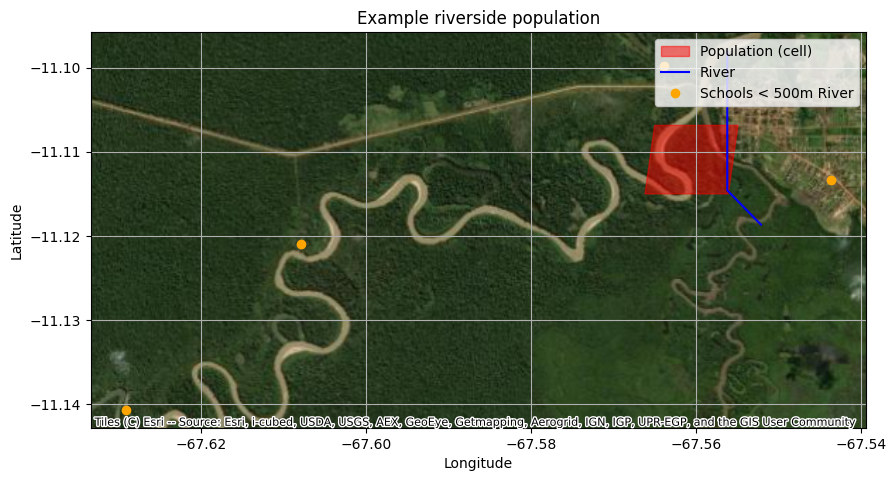

In [71]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
polygon_example.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5)

amazon_rivers_gdf[
    amazon_rivers_gdf.intersects(polygon_example.iloc[0]["geometry"])
].plot(ax=ax, color="blue")

amazon_schools_primary_wrivers[
    amazon_schools_primary_wrivers.intersects(
        polygon_example.iloc[0]["geometry"].buffer(0.1)
    )
].plot(ax=ax, color="orange")

# Add the basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Example riverside population")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

pop_patch = mpatches.Patch(color="red", label="Population (cell)", alpha=0.5)
river_line = mlines.Line2D([], [], color="blue", label="River")
school_point = mlines.Line2D(
    [], [], color="orange", label="Schools < 500m River", linewidth=0, marker="o"
)

ax.legend(handles=[pop_patch, river_line, school_point], loc="upper right")

# Show the plot
plt.show()

In [72]:
isolated_cells_primary_wrivers = isolated_cells_primary_wrivers_proj.to_crs(4326)
isolated_cells_middle_wrivers = isolated_cells_middle_wrivers_proj.to_crs(4326)
isolated_cells_secondary_wrivers = isolated_cells_secondary_wrivers_proj.to_crs(4326)

In [73]:
isolated_cells_primary_wrivers_ttimes = up.accessibility.travel_times(
    isolated_cells_primary_wrivers,
    amazon_schools_primary_wrivers,
    col_label="nearest_primary_school_by_river",
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/1919 [00:00<?, ?it/s]

In [74]:
isolated_cells_middle_wrivers_ttimes = up.accessibility.travel_times(
    isolated_cells_middle_wrivers,
    amazon_schools_middle_wrivers,
    col_label="nearest_middle_school_by_river",
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/1162 [00:00<?, ?it/s]

In [75]:
isolated_cells_secondary_wrivers_ttimes = up.accessibility.travel_times(
    isolated_cells_secondary_wrivers,
    amazon_schools_secondary_wrivers,
    col_label="nearest_secondary_school_by_river",
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/1696 [00:00<?, ?it/s]

In [76]:
print(
    "Isolated cells (No access to primary schools by land)",
    isolated_cells_primary_wrivers_ttimes.shape[0],
)
print(
    "Isolated cells (No access to primary schools but accessible by river)",
    isolated_cells_primary_wrivers_ttimes.shape[0]
    - isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ]
    .isna()
    .sum(),
)
print(
    "Isolated cells (No access to primary schools by land nor river)",
    isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ]
    .isna()
    .sum(),
)

Isolated cells (No access to primary schools by land) 1919
Isolated cells (No access to primary schools but accessible by river) 1566
Isolated cells (No access to primary schools by land nor river) 353


In [77]:
isolated_cells_primary_wrivers_ttimes[
    "duration_to_nearest_nearest_primary_school_by_river_label"
].value_counts().sort_index()

duration_to_nearest_nearest_primary_school_by_river_label
0-15      899
15-30     147
30-45     106
45-60      64
60-90      83
90-120     40
>120      227
Name: count, dtype: int64

In [79]:
print(
    "Isolated cells (No access to middle schools by land)",
    isolated_cells_middle_wrivers_ttimes.shape[0],
)
print(
    "Isolated cells (No access to middle schools but accessible by river)",
    isolated_cells_middle_wrivers_ttimes.shape[0]
    - isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ]
    .isna()
    .sum(),
)
print(
    "Isolated cells (No access to middle schools by land nor river)",
    isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ]
    .isna()
    .sum(),
)

Isolated cells (No access to middle schools by land) 1162
Isolated cells (No access to middle schools but accessible by river) 826
Isolated cells (No access to middle schools by land nor river) 336


In [80]:
isolated_cells_middle_wrivers_ttimes[
    "duration_to_nearest_nearest_middle_school_by_river_label"
].value_counts().sort_index()

duration_to_nearest_nearest_middle_school_by_river_label
0-15      328
15-30      62
30-45      60
45-60      60
60-90      44
90-120     28
>120      244
Name: count, dtype: int64

In [81]:
print(
    "Isolated cells (No access to secondary schools by land)",
    isolated_cells_secondary_wrivers_ttimes.shape[0],
)
print(
    "Isolated cells (No access to secondary schools but accessible by river)",
    isolated_cells_secondary_wrivers_ttimes.shape[0]
    - isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ]
    .isna()
    .sum(),
)
print(
    "Isolated cells (No access to secondary schools by land nor river)",
    isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ]
    .isna()
    .sum(),
)

Isolated cells (No access to secondary schools by land) 1696
Isolated cells (No access to secondary schools but accessible by river) 1384
Isolated cells (No access to secondary schools by land nor river) 312


In [82]:
isolated_cells_primary_wrivers_ttimes.columns

Index(['cell_id', 'polygon_id', 'category', 'country', 'pop_total',
       'pop_primary_school_age', 'pop_middle_school_age',
       'pop_secondary_school_age', 'distance_to_nearest_primary_schools',
       'duration_to_nearest_primary_schools',
       'duration_to_nearest_primary_schools_label',
       'distance_to_nearest_middle_schools',
       'duration_to_nearest_middle_schools',
       'duration_to_nearest_middle_schools_label',
       'distance_to_nearest_secondary_schools',
       'duration_to_nearest_secondary_schools',
       'duration_to_nearest_secondary_schools_label', 'geometry', 'lon', 'lat',
       'index_right', 'HYRIV_ID', 'NEXT_DOWN', 'MAIN_RIV', 'LENGTH_KM',
       'DIST_DN_KM', 'DIST_UP_KM', 'CATCH_SKM', 'UPLAND_SKM', 'ENDORHEIC',
       'DIS_AV_CMS', 'ORD_STRA', 'ORD_CLAS', 'ORD_FLOW', 'HYBAS_L12',
       'distance_to_river', 'nearest_nearest_primary_school_by_river_ix',
       'distance_to_nearest_nearest_primary_school_by_river',
       'duration_to_nearest_near

In [83]:
# Calculate population for the three categories for primary level:
# 1. Total isolated (all rows in isolated_cells_primary_proj)
# 2. Not near river (distance_to_river isna in isolated_cells_primary_wrivers_proj)
# 3. Near river (distance_to_river notna in isolated_cells_primary_wrivers_proj)

pop_isolated_primary = isolated_cells_primary_wrivers_ttimes[
    "pop_primary_school_age"
].sum()
pop_not_near_river_primary = isolated_cells_primary_wrivers_ttimes[
    isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ].isna()
]["pop_primary_school_age"].sum()
pop_near_river_primary = isolated_cells_primary_wrivers_ttimes[
    isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ].notna()
]["pop_primary_school_age"].sum()

print("Total Primary level population:")
print("No access by land:", int(pop_isolated_primary))
print("No access by land nor river:", int(pop_not_near_river_primary))
print("No access by river but no land:", int(pop_near_river_primary))

print("\nMiddle level:")

# Calculate population for the three categories for middle level:
# 1. Total isolated (all rows in isolated_cells_middle_proj)
# 2. Not near river (distance_to_river isna in isolated_cells_middle_wrivers_proj)
# 3. Near river (distance_to_river notna in isolated_cells_middle_wrivers_proj)

pop_isolated_middle = isolated_cells_middle_wrivers_ttimes[
    "pop_middle_school_age"
].sum()
pop_not_near_river_middle = isolated_cells_middle_wrivers_ttimes[
    isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ].isna()
]["pop_middle_school_age"].sum()
pop_near_river_middle = isolated_cells_middle_wrivers_ttimes[
    isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ].notna()
]["pop_middle_school_age"].sum()

print("Total population without access by land:", int(pop_isolated_middle))
print("No access by land nor river:", int(pop_not_near_river_middle))
print("No access by river but no land:", int(pop_near_river_middle))

print("\nSecondary level:")


# Calculate population for the three categories for secondary level:
# 1. Total isolated (all rows in isolated_cells_secondary_proj)
# 2. Not near river (distance_to_river isna in isolated_cells_secondary_wrivers_proj)
# 3. Near river (distance_to_river notna in isolated_cells_secondary_wrivers_proj)

pop_isolated = isolated_cells_secondary_wrivers_ttimes["pop_secondary_school_age"].sum()
pop_not_near_river = isolated_cells_secondary_wrivers_ttimes[
    isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ].isna()
]["pop_secondary_school_age"].sum()
pop_near_river = isolated_cells_secondary_wrivers_ttimes[
    isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ].notna()
]["pop_secondary_school_age"].sum()

print("Total population without access by land:", int(pop_isolated))
print("No access by land nor river:", int(pop_not_near_river))
print("No access by river but no land:", int(pop_near_river))

# Put a phrase like "In total more than X school-age children live completely isolated from their corresponding schools

print(
    "\nIn total, more than "
    + str(
        int(pop_not_near_river_middle + pop_not_near_river_primary + pop_not_near_river)
    )
    + " school-age children live completely isolated from their corresponding schools."
)

Total Primary level population:
No access by land: 25105
No access by land nor river: 7042
No access by river but no land: 18062

Middle level:
Total population without access by land: 24659
No access by land nor river: 5781
No access by river but no land: 18878

Secondary level:
Total population without access by land: 21964
No access by land nor river: 5395
No access by river but no land: 16568

In total, more than 18220 school-age children live completely isolated from their corresponding schools.


In [84]:
isolated_cells_secondary_wrivers_ttimes[
    "duration_to_nearest_nearest_secondary_school_by_river_label"
].value_counts().sort_index()

duration_to_nearest_nearest_secondary_school_by_river_label
0-15      694
15-30     146
30-45     103
45-60      80
60-90      89
90-120     44
>120      228
Name: count, dtype: int64

In [85]:
isolated_cells_secondary_wrivers_ttimes

,cell_id,polygon_id,category,country,pop_total,pop_primary_school_age,pop_middle_school_age,pop_secondary_school_age,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,...,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,distance_to_river,nearest_nearest_secondary_school_by_river_ix,distance_to_nearest_nearest_secondary_school_by_river,duration_to_nearest_nearest_secondary_school_by_river,duration_to_nearest_nearest_secondary_school_by_river_label
77,14243,05659-1-1,non_urban_area,bol,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,30.954,5.0,5.0,5.0,6.120581e+09,0.0,10523,0.1937,0.155000,0-15
78,14244,09253-1-1,non_urban_area,bol,0.390922,0.130375,0.129348,0.131199,0.0,0.0,...,30.954,5.0,5.0,5.0,6.120581e+09,0.0,10523,2.3791,14.275000,0-15
286,14842,08866-1-1,non_urban_area,bol,0.479630,0.166504,0.152532,0.160594,0.0,0.0,...,2.020,2.0,7.0,6.0,6.121171e+09,0.0,1033,0.0857,0.515000,0-15
367,14953,08329-1-1,non_urban_area,bol,0.287285,0.099731,0.091363,0.096191,0.0,0.0,...,0.336,1.0,6.0,7.0,6.121174e+09,0.0,152,2.3896,14.338333,0-15
920,15558,08244-1-1,non_urban_area,bol,9.247681,3.250939,2.950496,3.046246,0.0,0.0,...,0.307,1.0,8.0,7.0,6.121200e+09,0.0,940,0.0758,0.100000,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35349,35138,00174-1-1,non_urban_area,bra,48.574770,16.172029,16.620049,15.782691,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3819,0.0000,0.000000,NaN
35362,35477,04394-1-1,non_urban_area,bra,86.500083,29.331085,28.196283,28.972714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3779,0.0000,0.000000,NaN
35363,35478,04394-1-1,non_urban_area,bra,63.682124,21.593804,20.758352,21.329967,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3779,0.0000,0.000000,NaN
35364,35490,04394-1-1,non_urban_area,bra,170.997419,57.983065,55.739737,57.274618,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3779,0.0000,0.000000,NaN


In [86]:
# Calculate population by education level, type of access (no access, only by river), and country
pop_access_summary = []

for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    wriver_ttimes = globals()[f"{wriver_name.replace('_proj', '')}_ttimes"]
    # Group by country for both no access and only by river
    for country, group in wriver_ttimes.groupby("country"):
        # No access by land nor river: duration label isna
        pop_no_access = group[
            group[
                f"duration_to_nearest_nearest_{level.lower()}_school_by_river_label"
            ].isna()
        ][pop_col].sum()
        # Only by river: duration label is notna
        pop_only_by_river = group[
            group[
                f"duration_to_nearest_nearest_{level.lower()}_school_by_river_label"
            ].notna()
        ][pop_col].sum()
        pop_access_summary.append(
            [level, country, int(pop_no_access), int(pop_only_by_river)]
        )

df_pop_access_summary_country = pd.DataFrame(
    pop_access_summary,
    columns=["Level", "Country", "No access (land nor river)", "Only by river"],
)
df_pop_access_summary_country

,Level,Country,No access (land nor river),Only by river
0,Primary,bol,393,458
1,Primary,bra,4168,13465
2,Primary,col,20,63
3,Primary,ecu,369,1192
4,Primary,per,2090,2883
5,Middle,bol,197,457
6,Middle,bra,4009,15138
7,Middle,col,8,53
8,Middle,ecu,406,1209
9,Middle,per,1159,2019


In [87]:
# Analyze populations with only river access per education level, travel time label, and country

pop_river_access_by_time = []

for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    wriver_ttimes = globals()[f"{wriver_name.replace('_proj', '')}_ttimes"]
    label_col = f"duration_to_nearest_nearest_{level.lower()}_school_by_river_label"
    # Only cells with access by river (label notna)
    df = wriver_ttimes[wriver_ttimes[label_col].notna()]
    summary = (
        df.groupby([label_col, "country"])[pop_col]
        .sum()
        .reset_index()
        .rename(columns={pop_col: "population"})
    )
    summary["Level"] = level
    pop_river_access_by_time.append(summary)

# Concatenate results for all levels
df_pop_river_access_by_time = pd.concat(pop_river_access_by_time, ignore_index=True)
df_pop_river_access_by_time

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/3401446543.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([label_col, "country"])[pop_col]
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/3401446543.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([label_col, "country"])[pop_col]
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/3401446543.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

,duration_to_nearest_nearest_primary_school_by_river_label,country,population,Level,duration_to_nearest_nearest_middle_school_by_river_label,duration_to_nearest_nearest_secondary_school_by_river_label
0,0-15,bol,456.567597,Primary,NaN,NaN
1,0-15,bra,10058.339735,Primary,NaN,NaN
2,0-15,col,31.128430,Primary,NaN,NaN
3,0-15,ecu,1143.988694,Primary,NaN,NaN
4,0-15,per,2462.013503,Primary,NaN,NaN
...,...,...,...,...,...,...
100,NaN,bol,0.363235,Secondary,NaN,>120
101,NaN,bra,835.885620,Secondary,NaN,>120
102,NaN,col,18.399158,Secondary,NaN,>120
103,NaN,ecu,0.559696,Secondary,NaN,>120


In [88]:
df_pop_river_access_by_time.columns

Index(['duration_to_nearest_nearest_primary_school_by_river_label', 'country',
       'population', 'Level',
       'duration_to_nearest_nearest_middle_school_by_river_label',
       'duration_to_nearest_nearest_secondary_school_by_river_label'],
      dtype='object')

In [89]:
# Clean df_pop_river_access_by_time: unify travel time label column and set MultiIndex

# Find the travel time label column (it starts with 'duration_to_nearest_nearest_')
label_cols = [col for col in df_pop_river_access_by_time.columns if col.startswith('duration_to_nearest_nearest_')]

# Rename the travel time label column to 'travel_time_label'
df_pop_river_access_by_time_clean = df_pop_river_access_by_time.rename(
    columns={label_cols[0]: 'travel_time_label'}
)

# Fill na values in the travel time label column with the other travel time label columns
df_pop_river_access_by_time_clean['travel_time_label'] = (
    df_pop_river_access_by_time_clean['travel_time_label']
        .fillna(df_pop_river_access_by_time_clean[label_cols[1]])
        .fillna(df_pop_river_access_by_time_clean[label_cols[2]])
    )

# Drop the other travel time label columns
df_pop_river_access_by_time_clean = df_pop_river_access_by_time_clean.drop(columns=label_cols[1:])

# Set MultiIndex (Level, Country, travel_time_label)
df_pop_river_access_by_time_clean = df_pop_river_access_by_time_clean.set_index(['Level', 'country', 'travel_time_label'])

# Optional: sort index for better Excel analysis
df_pop_river_access_by_time_clean = df_pop_river_access_by_time_clean.sort_index()

df_pop_river_access_by_time_clean["population"] = df_pop_river_access_by_time_clean["population"].round().astype(int)

df_pop_river_access_by_time_clean

population
Level     country travel_time_label            
Middle    bol     0-15                      426
                  15-30                      17
                  30-45                       0
                  45-60                       0
                  60-90                       0
...                                         ...
Secondary per     30-45                     234
                  45-60                      27
                  60-90                      29
                  90-120                     76
                  >120                       27

[105 rows x 1 columns]

In [90]:
df_pop_river_access_by_time_clean.to_clipboard()

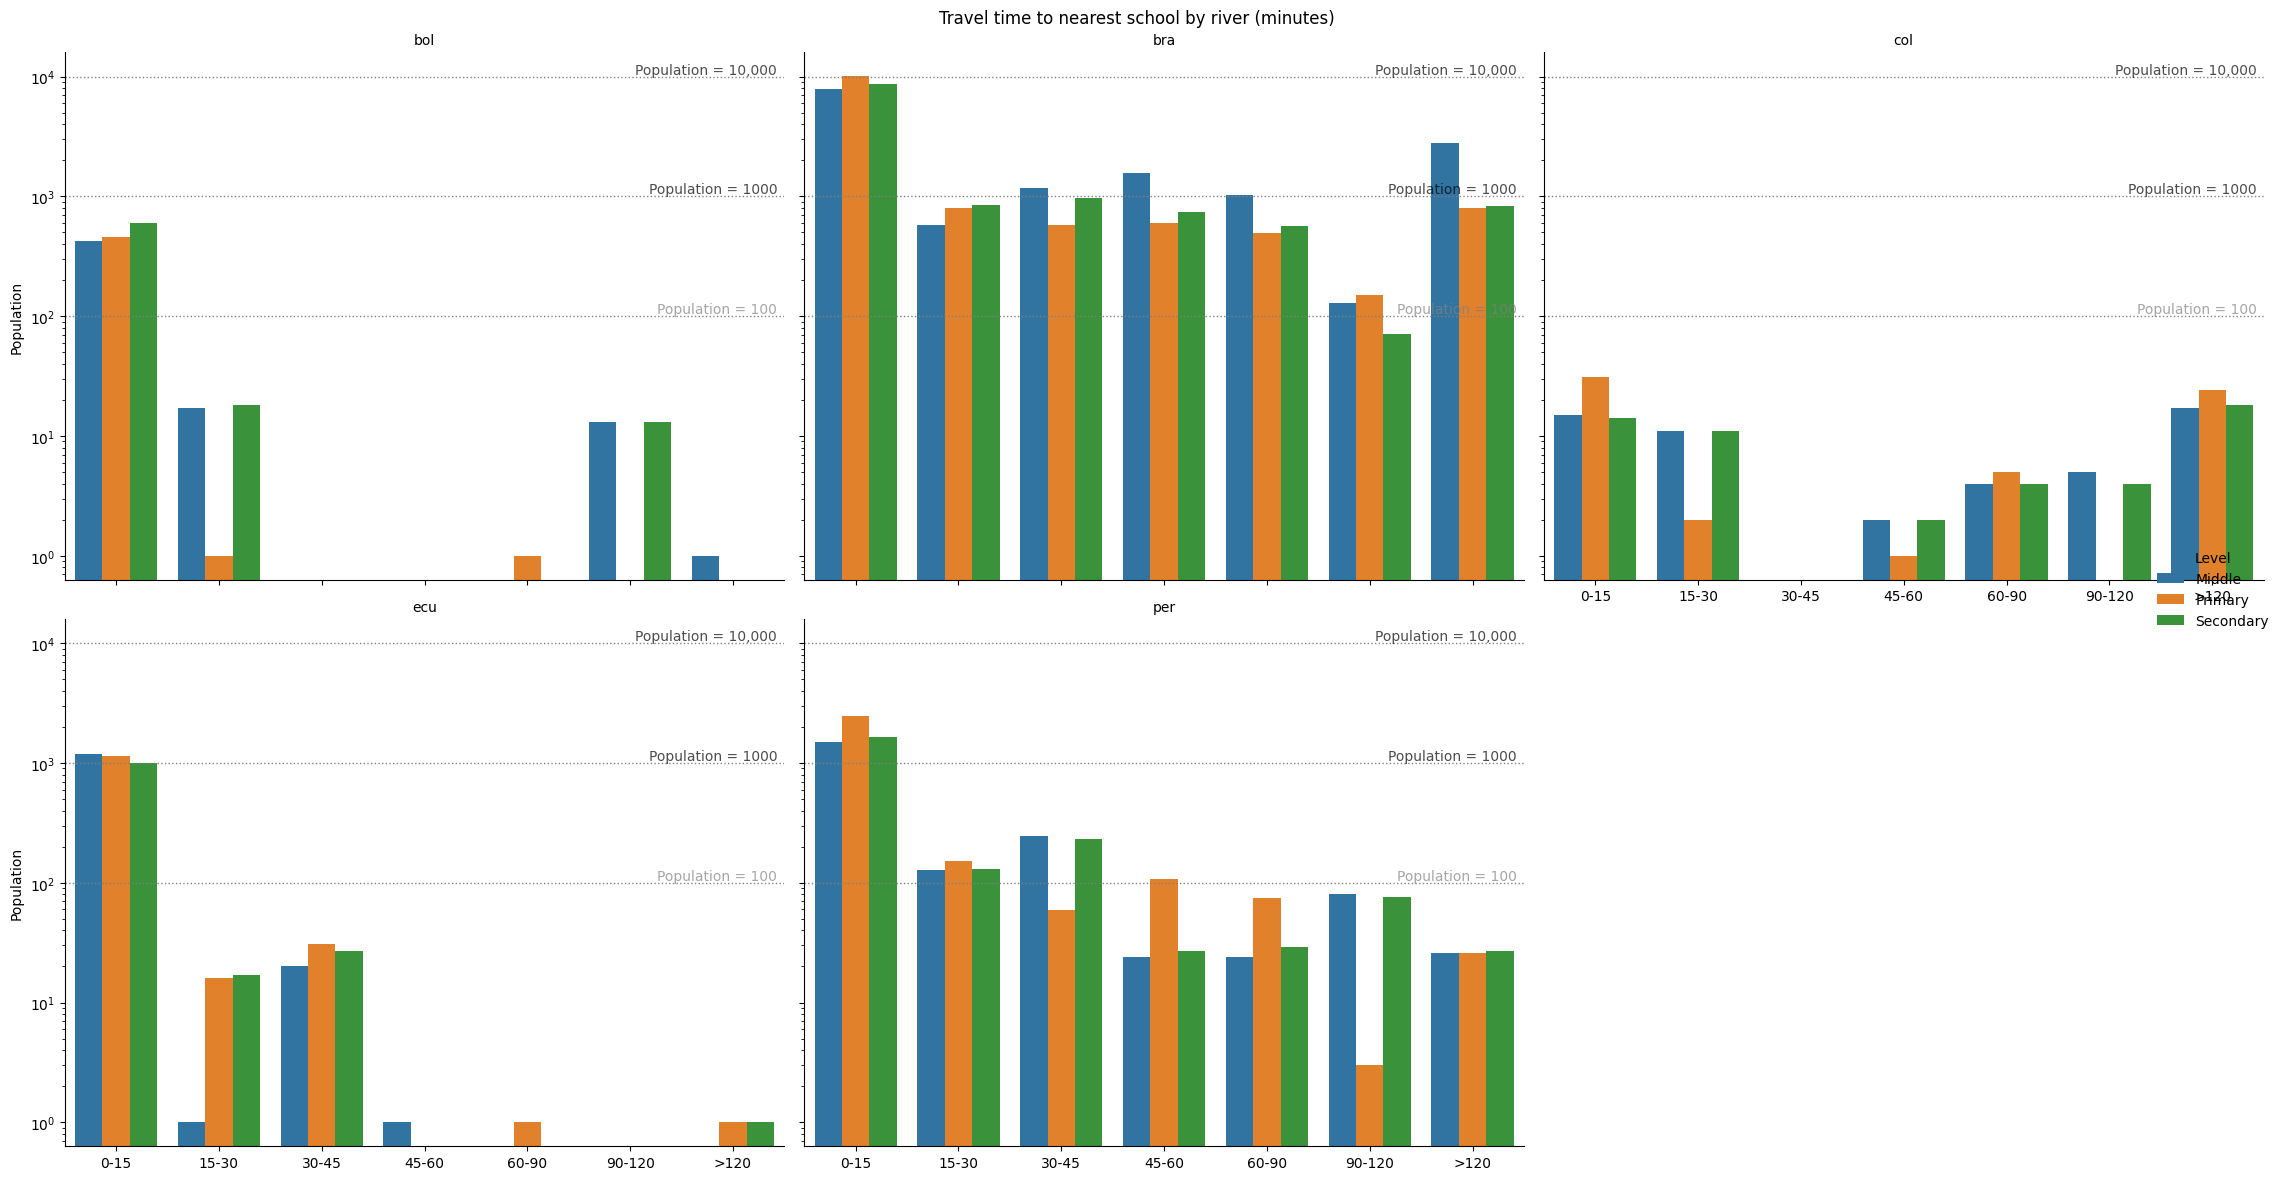

In [91]:
import seaborn as sns

# Reset index for plotting
df_plot = df_pop_river_access_by_time_clean.reset_index()

g = sns.catplot(
    data=df_plot,
    x="travel_time_label",
    y="population",
    hue="Level",
    col="country",
    kind="bar",
    height=6,
    aspect=1.2,
    col_wrap=3,
    sharex=True,
    sharey=True,
)
g.figure.suptitle("Travel time to nearest school by river (minutes)")
g.set(yscale="log")
g.set_axis_labels("", "Population")
g.set_titles("{col_name}")

# Add horizontal grid lines
for ax in g.axes.flatten():
    # Add horizontal lines at 100 and 1000
    ax.axhline(100, color="gray", linestyle=":", linewidth=1)
    ax.text(
        0.99,
        100,
        "Population = 100",
        color="gray",
        fontsize=10,
        va="bottom",
        ha="right",
        transform=ax.get_yaxis_transform(),
        alpha=0.7,
    )
    ax.axhline(1000, color="gray", linestyle=":", linewidth=1)
    ax.text(
        0.99,
        1000,
        "Population = 1000",
        color="k",
        fontsize=10,
        va="bottom",
        ha="right",
        transform=ax.get_yaxis_transform(),
        alpha=0.7,
    )
    ax.axhline(10000, color="gray", linestyle=":", linewidth=1)
    ax.text(
        0.99,
        10000,
        "Population = 10,000",
        color="k",
        fontsize=10,
        va="bottom",
        ha="right",
        transform=ax.get_yaxis_transform(),
        alpha=0.7,
    )


plt.tight_layout()
plt.show()

In [92]:
df_pop_river_access_by_time_clean.to_excel(
    "outputs/riverside_pop_school_access_2025_07_29.xlsx", index=True
)

In [93]:
df_pop_river_access_by_time_clean.sum()

population    53508
dtype: int64

In [94]:
pd.DataFrame(
    {
        "population": df_pop_river_access_by_time_clean.groupby("country")[
            "population"
        ].sum(),
        "% of total population": (
            (
                df_pop_river_access_by_time_clean.groupby("country")["population"].sum()
                / df_pop_river_access_by_time_clean["population"].sum()
                * 100
            ).round(2)
        ),
    }
)

,population,% of total population
country,,
bol,1544,2.89
bra,41268,77.12
col,170,0.32
ecu,3451,6.45
per,7075,13.22


In [95]:
pd.DataFrame(
    {
        "population": df_pop_river_access_by_time_clean.groupby("Level")[
            "population"
        ].sum(),
        "% of total population": (
            (
                df_pop_river_access_by_time_clean.groupby("Level")["population"].sum()
                / df_pop_river_access_by_time_clean["population"].sum()
                * 100
            ).round(2)
        ),
    }
)

,population,% of total population
Level,,
Middle,18878,35.28
Primary,18063,33.76
Secondary,16567,30.96


In [96]:
pd.DataFrame(
    {
        "population": df_pop_river_access_by_time_clean.groupby("travel_time_label")[
            "population"
        ].sum(),
        "% of total population": (
            (
                df_pop_river_access_by_time_clean.groupby("travel_time_label")[
                    "population"
                ].sum()
                / df_pop_river_access_by_time_clean["population"].sum()
                * 100
            ).round(2)
        ),
    }
)

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/904961301.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "population": df_pop_river_access_by_time_clean.groupby("travel_time_label")[
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/904961301.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop_river_access_by_time_clean.groupby("travel_time_label")[


,population,% of total population
travel_time_label,,
0-15,37088,69.31
15-30,2723,5.09
30-45,3327,6.22
45-60,3062,5.72
60-90,2219,4.15
90-120,544,1.02
>120,4545,8.49


In [97]:
df_pop_river_access_by_time_clean.reset_index()["travel_time_label"]

0        0-15
1       15-30
2       30-45
3       45-60
4       60-90
        ...  
100     30-45
101     45-60
102     60-90
103    90-120
104      >120
Name: travel_time_label, Length: 105, dtype: category
Categories (7, object): ['0-15' < '15-30' < '30-45' < '45-60' < '60-90' < '90-120' < '>120']

In [98]:
df_pop_river_access_by_time_clean[
    (
        df_pop_river_access_by_time_clean.reset_index()["travel_time_label"] > "15-30"
    ).values
]["population"].sum()

np.int64(13697)

In [100]:
# Isolated cells (No access to primary schools by land) 1919
# Isolated cells (No access to primary schools but accessible by river) 1139
# Isolated cells (No access to primary schools by land nor river) 780

# Isolated cells (No access to middle schools by land) 1162
# Isolated cells (No access to middle schools but accessible by river) 847
# Isolated cells (No access to middle schools by land nor river) 315

# Isolated cells (No access to secondary schools by land) 1696
# Isolated cells (No access to secondary schools but accessible by river) 1088
# Isolated cells (No access to secondary schools by land nor river) 608

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_92434/483032733.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot_data.groupby(["Level", "travel_time_label"])["population"]


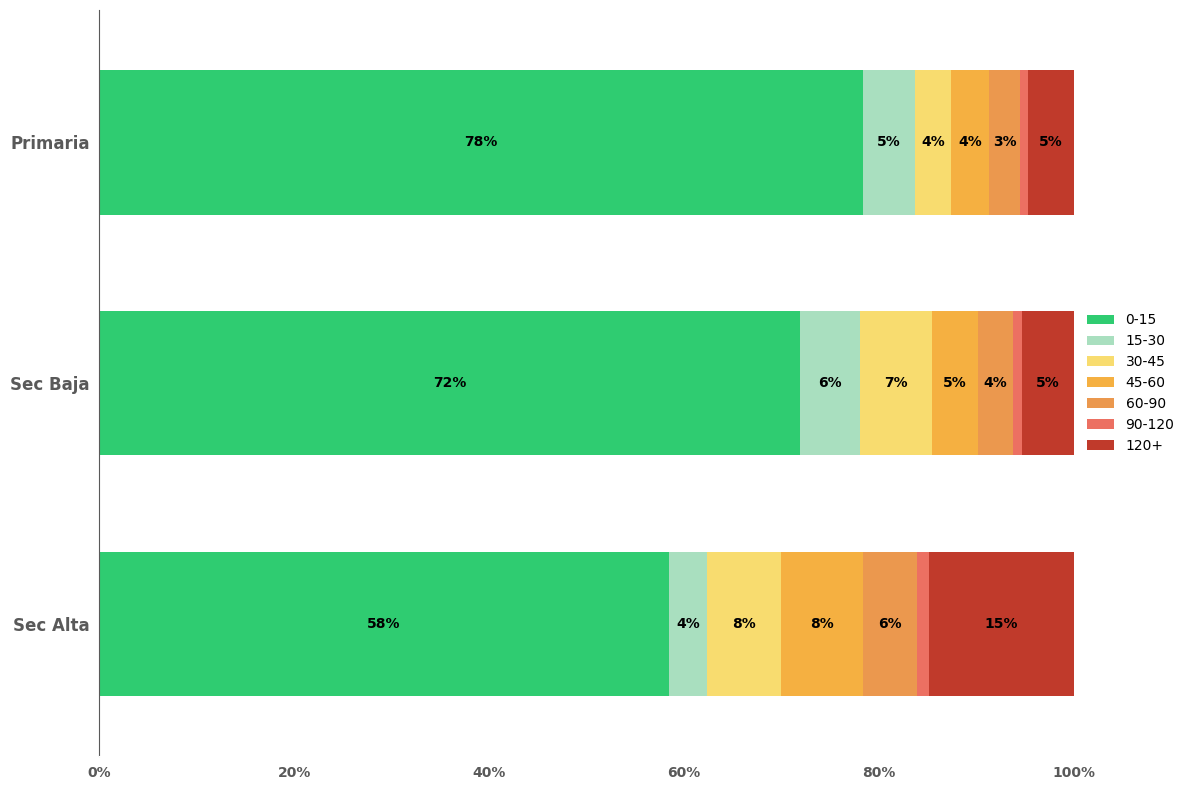

Percentages by educational level and travel time:
travel_time_label  0-15  15-30  30-45  45-60  60-90  90-120  >120
Level                                                            
Middle             58.4    3.9    7.6    8.4    5.6     1.2  14.9
Secondary          71.9    6.2    7.4    4.6    3.6     1.0   5.3
Primary            78.3    5.4    3.7    3.9    3.2     0.8   4.7


In [ ]:
# Create the plot: Porcentaje de la Población Escolar Ribereña según Tiempo de Viaje Fluvial
# Calculate percentages by educational level

# Reset index to work with the data
df_plot_data = df_pop_river_access_by_time_clean.reset_index()

# Group by Level and travel_time_label to get total population per category
df_grouped = (
    df_plot_data.groupby(["Level", "travel_time_label"])["population"]
    .sum()
    .reset_index()
)

# Calculate total population per educational level
level_totals = df_grouped.groupby("Level")["population"].sum()

# Calculate percentages
df_grouped["percentage"] = df_grouped.apply(
    lambda row: (row["population"] / level_totals[row["Level"]]) * 100, axis=1
)

# Pivot to get travel_time_label as columns
df_pivot = df_grouped.pivot(
    index="Level", columns="travel_time_label", values="percentage"
).fillna(0)

# Define the order for travel time categories and educational levels
time_order = ["0-15", "15-30", "30-45", "45-60", "60-90", "90-120", ">120"]
level_order = ["Middle", "Secondary", "Primary"]

# Reindex to ensure proper order
df_pivot = df_pivot.reindex(index=level_order, columns=time_order, fill_value=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each time category (matching the image)
colors = ["#2fcc71", "#a9dfbf", "#f8dc6f", "#f5b041", "#eb984e", "#ec7062", "#c03a2b"]

# Create horizontal stacked bar chart
df_pivot.plot(kind="barh", stacked=True, ax=ax, color=colors, width=0.6)

# Customize the plot
# ax.set_title(
#     "Figura 10. Porcentaje de la Población Escolar Ribereña según Tiempo de Viaje Fluvial,\nSegún Nivel Educativo. Territorios Amazónicos de 5 países.",
#     fontsize=14,
#     fontweight="bold",
#     pad=20,
# )

# Set labels
# ax.set_xlabel("Porcentaje (%)", fontsize=12)
ax.set_ylabel("")

# Customize y-axis labels to match the image
level_labels = {
    "Primary": "Primaria",
    "Secondary": "Sec Baja",
    "Middle": "Sec Alta",
}
ax.set_yticklabels(
    [level_labels[level] for level in level_order],
    fontdict={
        "fontsize": 12,
        "fontweight": "bold",
        "color": "#595959",
    },
)

# Set x-axis to show 0-100%
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 20))

# Add percentage labels on bars for significant segments
for i, level in enumerate(level_order):
    x_pos = 0
    for j, time_cat in enumerate(time_order):
        width = df_pivot.loc[level, time_cat]
        if width > 2:  # Only show labels for segments > 5%
            ax.text(
                x_pos + width / 2,
                i,
                f"{width:.0f}%",
                ha="center",
                va="center",
                fontweight="bold",
                fontsize=10,
            )
        x_pos += width

# Customize legend
legend_labels = ["0-15", "15-30", "30-45", "45-60", "60-90", "90-120", "120+"]
ax.legend(
    legend_labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    # title="Tiempo de viaje (minutos)",
    frameon=False,
)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add grid for better readability
ax.grid(axis="x", alpha=0, linestyle="--")

# Set x-axis line color to white/transparent
ax.spines["left"].set_color("#595959")
ax.spines["bottom"].set_color("white")
# Remove x-axis ticks and labels, but keep the percentage labels
ax.set_xticklabels(
    ["0%", "20%", "40%", "60%", "80%", "100%"],
    fontdict={
        "fontsize": 10,
        "fontweight": "bold",
        "color": "#595959",
    },
)
ax.tick_params(width=0)
plt.tight_layout()
plt.savefig(
    "outputs/figura_10_porcentaje_poblacion_escolar_riberenia.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Print the actual percentages for verification
print("Percentages by educational level and travel time:")
print(df_pivot.round(1))